Trading prediction

Importuri necesare

In [7]:
import pandas as pd
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
# Pentru modele și evaluare
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Pentru rețeaua neuronală (Keras)
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense


# LSTM din TensorFlow/Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM                      # Pentru manipularea datelor în DataFrame          # Pentru generarea de grafice (folosit mai jos)

# Scikit‑learn – modele, scalere și metrici
from sklearn.preprocessing import MinMaxScaler             # Pentru normalizarea 0–1        
from sklearn.model_selection import GridSearchCV            # Căutare grilă hiperparametri 
from sklearn.linear_model import Ridge                      # Regresie liniară cu penalizare L2

import tensorflow as tf         # Model secvențial Keras
from tensorflow.keras.layers import  Dropout, Input  # Straturi LSTM și dense
             
from tensorflow.keras.callbacks import EarlyStopping       # Callback pentru oprire timpurie




Încărcarea dataset-ului
Încărcarea datelor:
• Se definește calea către fișierul CSV și se încarcă datele într-un DataFrame folosind pd.read_csv(), apoi se afișează numele coloanelor pentru a verifica structura datelor.

Conversia Timestamp în format datetime:
• Se utilizează pd.to_datetime() pentru a transforma valorile din coloana 'Timestamp' în obiecte de tip datetime, specificând unitatea 's' (secunde) și folosind errors='coerce' pentru a converti eventualele valori invalide în NaT (Not a Time).

Crearea unei coloane cu timestamp numeric:
• Se aplică o funcție lambda pe coloana 'Date' pentru a converti fiecare valoare datetime într-un timestamp numeric (numărul de secunde), păstrând np.nan pentru valorile lipsă, și se salvează rezultatul în coloana 'NumericTimestamp'.

Eliminarea coloanelor non-numerice și calculul corelației:
• Se elimină coloanele 'Date' și 'Timestamp' (care nu sunt numerice) folosind drop(), astfel încât să se păstreze doar coloanele numerice, iar apoi se calculează matricea de corelație între aceste coloane folosind corr().

Corelația Pearson:
• Măsoară relația liniară dintre două variabile. Valorile variază între –1 (corelație negativă perfectă) și +1 (corelație pozitivă perfectă).

In [9]:
file_path = "C:\\Users\\Marian.Pop\\Downloads\\btcusd_1-min_data.csv"
data = pd.read_csv(file_path)
print(data.columns)

# Convertește coloana 'Timestamp' în datetime (folosind errors='coerce' pentru a transforma valorile invalide în NaT)
data['Date'] = pd.to_datetime(data['Timestamp'], unit='s', errors='coerce')
# Tratarea valorilor lipsă fără a le elimina
data['NumericTimestamp'] = data['Date'].apply(lambda x: x.timestamp() if pd.notnull(x) else np.nan)

# Elimină coloanele non-numerice pentru calculul corelațiilor
numeric_data = data.drop(columns=['Date', 'Timestamp'])
corr_matrix = numeric_data.corr()
print(numeric_data.corr())

print(corr_matrix['Close'].sort_values(ascending=False))

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
                      Open      High       Low     Close    Volume  \
Open              1.000000  1.000000  1.000000  0.999999 -0.084553   
High              1.000000  1.000000  0.999999  1.000000 -0.084472   
Low               1.000000  0.999999  1.000000  1.000000 -0.084650   
Close             0.999999  1.000000  1.000000  1.000000 -0.084561   
Volume           -0.084553 -0.084472 -0.084650 -0.084561  1.000000   
NumericTimestamp  0.789259  0.789239  0.789282  0.789259 -0.079790   

                  NumericTimestamp  
Open                      0.789259  
High                      0.789239  
Low                       0.789282  
Close                     0.789259  
Volume                   -0.079790  
NumericTimestamp          1.000000  
Close               1.000000
High                1.000000
Low                 1.000000
Open                0.999999
NumericTimestamp    0.789259
Volume             -0.0845

 data.describe() calculează și afișează un rezumat statistic al coloanelor numerice din DataFrame, incluzând numărul de înregistrări (count), 
 media (mean), abaterea standard (std), valorile minime și maxime, precum și percentila 25%, 50% (mediană) și 75%.

In [10]:
data.describe()

,Timestamp,Open,High,Low,Close,Volume,Date,NumericTimestamp
count,6.781280e+06,6.781281e+06,6.781281e+06,6.781281e+06,6.781281e+06,6.781281e+06,6781280,6.781280e+06
mean,1.528948e+09,1.509086e+04,1.509729e+04,1.508421e+04,1.509087e+04,5.438073e+00,2018-06-14 03:39:19.117086720,1.528948e+09
min,1.325412e+09,3.800000e+00,3.800000e+00,3.800000e+00,3.800000e+00,0.000000e+00,2012-01-01 10:01:00,1.325412e+09
25%,1.427142e+09,4.151000e+02,4.152100e+02,4.150000e+02,4.150900e+02,1.848367e-02,2015-03-23 20:20:45,1.427142e+09
50%,1.528872e+09,6.328000e+03,6.329980e+03,6.325810e+03,6.328000e+03,4.970804e-01,2018-06-13 06:40:30,1.528872e+09
75%,1.630602e+09,2.373600e+04,2.374400e+04,2.372700e+04,2.373570e+04,3.156358e+00,2021-09-02 17:00:15,1.630602e+09
max,1.741824e+09,1.089460e+05,1.090300e+05,1.087760e+05,1.089600e+05,5.853852e+03,2025-03-13 00:00:00,1.741824e+09
std,1.175994e+08,2.071437e+04,2.072215e+04,2.070639e+04,2.071439e+04,2.287123e+01,NaN,1.175994e+08


 data.head(50) returnează primele 50 de rânduri din DataFrame, oferind o previzualizare rapidă a datelor.

In [ ]:
data.head(50)

,Timestamp,Open,High,Low,Close,Volume,Date,NumericTimestamp
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:01:00,1.325412e+09
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:02:00,1.325412e+09
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:03:00,1.325412e+09
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:04:00,1.325412e+09
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:05:00,1.325412e+09
5,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:06:00,1.325412e+09
6,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:07:00,1.325412e+09
7,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:08:00,1.325412e+09
8,1.325413e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:09:00,1.325413e+09
9,1.325413e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:10:00,1.325413e+09


 data.columns = data.columns.str.capitalize() transformă numele coloanelor, punând prima literă a fiecărui nume cu majusculă și restul cu minuscule.

In [12]:
data.columns = data.columns.str.capitalize()
print(data.columns)

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'Date',
       'Numerictimestamp'],
      dtype='object')


Conversia și sortarea datelor:
Se convertește coloana 'Date' în format datetime cu formatul '%Y-%m-%d %H:%M:%S' și se sortează DataFrame-ul în ordine cronologică.

Curățarea datelor:
Se elimină duplicatele și se filtrează rândurile cu volum zero pentru a asigura acuratețea analizei.

Resampling la date zilnice:
Se resamplează datele la nivel zilnic, agregând:

'Open' – prima valoare a zilei,
'High' – maximul zilei,
'Low' – minimul zilei,
'Close' – ultima valoare a zilei,
'Volume' – suma volumelor.

In [13]:
# Data Cleaning and Preprocessing
# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d %H:%M:%S')

# Sort by Date
data.sort_values('Date', inplace=True)

# Handle zero volume rows (optional: drop or replace)
data = data[data['Volume'] > 0]

# Resample to daily data
daily_data = data.set_index('Date').resample('D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).dropna()

Se resamplează datele zilnice la nivel anual, selectând ultima valoare a fiecărui an pentru prețul de închidere, rezultând în DataFrame-ul annual_data.
Se configurează o figură de 14x7 inch și se plotează linia prețului de închidere anual în albastru.
Se adaugă titlul graficului, etichete pentru axele x și y, legendă și grilă, iar graficul este afișat.

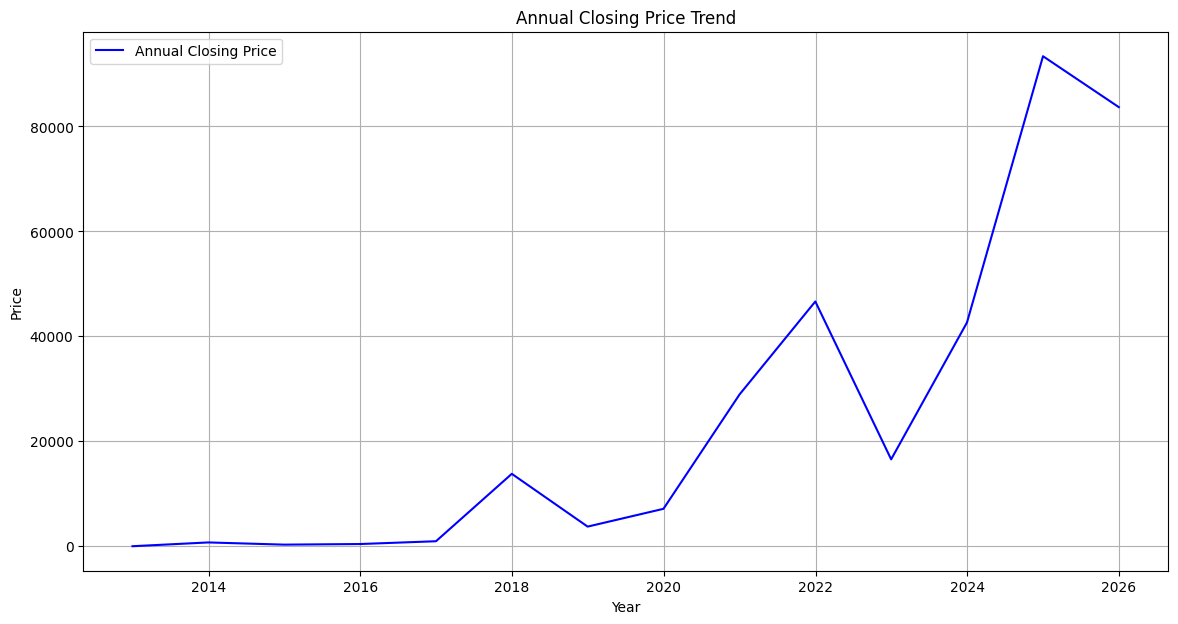

In [16]:
annual_data = daily_data.resample('YE').last()

plt.figure(figsize=(14, 7))
plt.plot(annual_data['Close'], label='Annual Closing Price', color='blue')
plt.title('Annual Closing Price Trend')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

Se plotează valorile zilnice din coloana 'Volume' ca linie de culoare portocalie, etichetată "Daily Volume".
Se adaugă titlul "Daily Volume Trend" și se etichetează axele (x: "Date", y: "Volume").
Se afișează legenda și grila, iar graficul este redat.

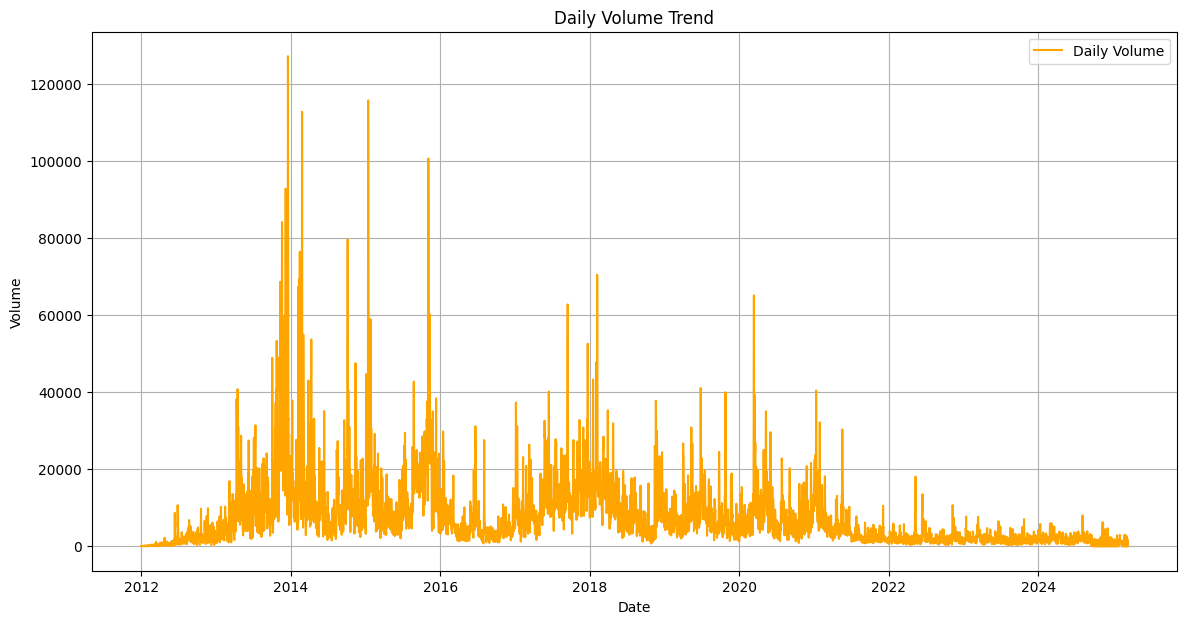

In [17]:
plt.figure(figsize=(14, 7))
plt.plot(daily_data['Volume'], label='Daily Volume', color='orange')
plt.title('Daily Volume Trend')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid()
plt.show()

Decompoziţia sezonieră (additivă) împarte seria “Close” în patru componente distincte:

Trend: evoluția pe termen lung — arată direcția generală (creștere, scădere sau stagnare) eliminând variațiile pe termen scurt.

Sezonal: fluctuațiile repetitive care se reiau anual (periodicitate de 365 de zile). Aceasta evidenţiază modele precum creșteri sau scăderi recurente în anumite luni/sezoane.

Rezidual: componenta „rest” — variația neexplicată de trend şi sezonalitate (zgomotul, evenimentele neașteptate sau factori necapturați de model).

Se generează un grafic cu subgrafice pentru componentele: Observat, Trend, Sezonal și Rezidual, care evidențiază diferitele aspecte ale seriei temporale.
Se afișează graficul rezultant.
Datele curățate și resample-ate sunt salvate într-un fișier CSV intitulat "btcusd_1-min_data.csv".
Se afișează un mesaj de confirmare că datele au fost curățate, resample-ate și vizualizate cu succes.

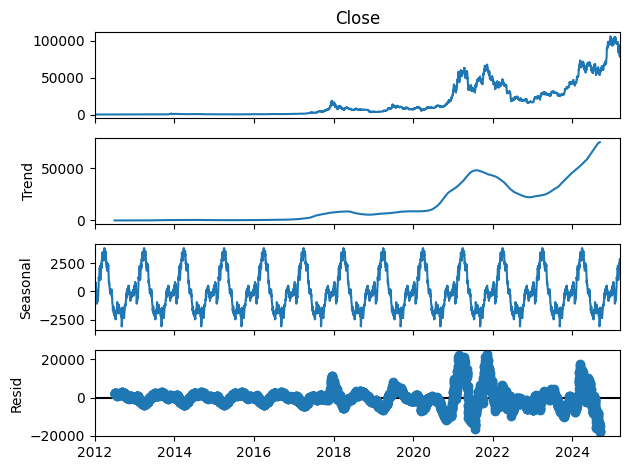

Data cleaned, resampled, and visualized. Saved as 'btcusd_1-min_data.csv'.


In [19]:
decompose_result = seasonal_decompose(daily_data['Close'], model='additive', period=365)

decompose_result.plot()
plt.show()

# Save cleaned and resampled data
daily_data.to_csv('btcusd_1-min_data.csv')

print("Data cleaned, resampled, and visualized. Saved as 'btcusd_1-min_data.csv'.")

Gini index (Close price): 0.9567
Entropy (Close price): 6.5759 bits


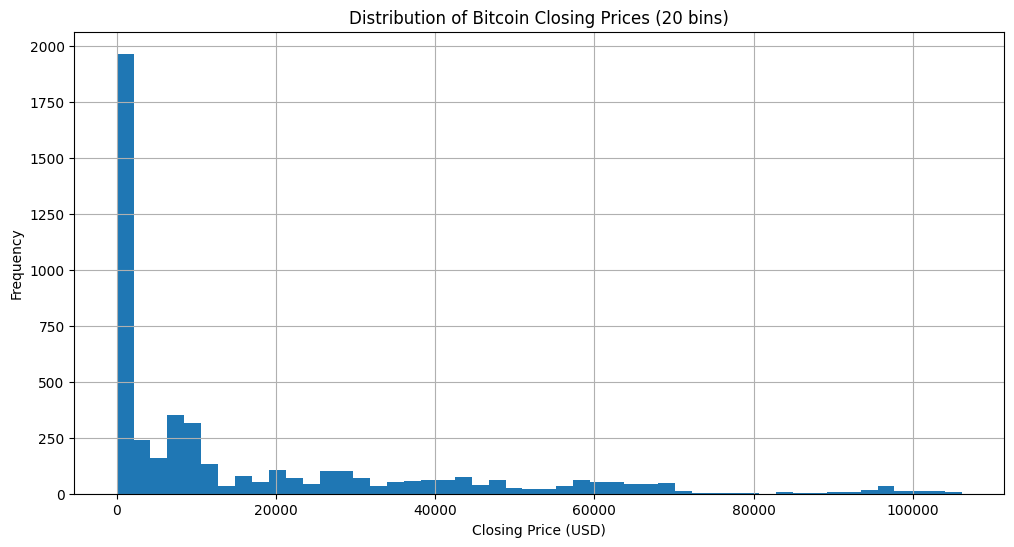

In [20]:

values = daily_data['Close'].dropna()

counts, _ = np.histogram(values, bins=500)

probs = counts[counts>0] / counts.sum()

entropy = -np.sum(probs * np.log2(probs))
gini_index = 1 - np.sum(probs**2)
print(f"Gini index (Close price): {gini_index:.4f}")

print(f"Entropy (Close price): {entropy:.4f} bits")


plt.figure(figsize=(12, 6))
plt.hist(daily_data['Close'].dropna(), bins=50)
plt.title('Distribution of Bitcoin Closing Prices (20 bins)')
plt.xlabel('Closing Price (USD)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

Indicele Hurst

Măsoară persistența (memoria) unei serii temporale.

Interpretare:
H>0.5: Seria este persistentă (tendința de a continua în aceeaşi direcţie).

H<0.5: Seria este anti-persistentă (tendinţa de inversare a trendului).

H=0.5: Seria se comportă ca un proces aleator (random walk).

In [21]:


def hurst_exponent(ts):
    """Calculează indicele Hurst pentru o serie temporală ts."""
    lags = range(2, 100)
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0]*2.0

close_prices = daily_data['Close'].dropna().values 
hurst = hurst_exponent(close_prices)
print(f"Indicele Hurst: {hurst:.4f}")


Indicele Hurst: 1.0954


Beta
Măsoară sensibilitatea activului față de mișcările unui indice de referință sau a pieței.

Interpretare:
Beta > 1: Activul este mai volatil decât piața.
Beta < 1: Activul este mai puțin volatil.
Beta = 1: Activul are volatilitate similară cu piața.

Pentru a calcula Beta, avem nevoie de serii temporale pentru prețul activului și pentru indicele de referință.
Beta = Cov(Ra, Rm) / Var(Rm)  
unde:  
- Ra = randamentul activului  
- Rm = randamentul pieței  
- Cov(Ra, Rm) = covarianța dintre randamentul activului și randamentul pieței  
- Var(Rm) = varianța randamentului pieței

O valoare Beta (0.5768) se interpretează astfel:

Subunitar: Deoarece Beta este mai mic decât 1, indică faptul că activul (Bitcoin) este mai puțin volatil decât indicele de referință.

Sensibilitate redusă: Dacă piaţa de referinţă se modifică cu 1% într-o anumită direcţie, preţul Bitcoin, conform modelului, se modifică în medie cu aproximativ 0.5768% în aceeaşi direcţie.

Risc sistematic mai scăzut: În contextul managementului riscului, un Beta sub 1 sugerează că activul are o expunere mai mică la mişcările pieţei, ceea ce poate fi interpretat ca un risc sistematic mai redus în comparaţie cu piaţa ca întreg.

In [23]:
import yfinance as yf


# Descărcăm date pentru un indice de piață, de exemplu S&P 500 (simbol: ^GSPC)
market_data = yf.download('^GSPC', start='2012-01-01', end='2022-12-31')

# Vom folosi prețul de închidere al indicele de piață
market_data = market_data[['Close']].rename(columns={'Close': 'Market_Close'})

print(market_data.head())
# Calculăm randamentele zilnice
daily_returns = daily_data['Close'].pct_change().dropna()
market_returns = market_data['Market_Close'].pct_change().dropna()

# Aliniem datele: presupunem că indexul lor este datetime și facem inner join
returns = pd.concat([daily_returns, market_returns], axis=1, join='inner')
returns.columns = ['Asset', 'Market']

# Calculăm Beta:
covariance = np.cov(returns['Asset'], returns['Market'])[0,1]
market_variance = np.var(returns['Market'])
beta = covariance / market_variance

print(f"Beta: {beta:.4f}")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price      Market_Close
Ticker            ^GSPC
Date                   
2012-01-03  1277.060059
2012-01-04  1277.300049
2012-01-05  1281.060059
2012-01-06  1277.810059
2012-01-09  1280.699951
Beta: 0.5768


In [24]:
PATH = r"C:\\Users\\Marian.Pop\\Downloads\\btcusd_1-min_data.csv"
data = pd.read_csv(PATH)

#  timestamp → datetime (secunde Unix)
data["Date"] = pd.to_datetime(data["Timestamp"], unit="s")
data.sort_values("Date", inplace=True)
data.set_index("Date", inplace=True)
data.drop(columns=["Timestamp"], inplace=True)

# ------------------------------------------------------------
# 2.  Trecem la rezoluție ZILNICĂ
# ------------------------------------------------------------
daily = data[["Open","High","Low","Close","Volume"]].resample("D").last().dropna()

# ------------------------------------------------------------
# 3.  Feature engineering (pe daily)
# ------------------------------------------------------------
lags = 5

df = daily.copy()
df["Return"]   = df["Close"].pct_change()
df["HighLow"]  = (df["High"] - df["Low"]) / df["Close"]
df["MA_5"]     = df["Close"].rolling(5).mean().pct_change()
df["Volume_N"] = (df["Volume"] - df["Volume"].rolling(5).mean())
df.dropna(inplace=True)        # eliminăm NaN-urile rezultate din rolling

feat_cols = ["Close","Return","HighLow","MA_5","Volume_N"]
F         = df[feat_cols].values            # (rows, n_feat)
n_feat    = F.shape[1]

# ------------------------------------------------------------
# 4.  Construim lag-cube X  (samples, lags, features)
#     și eticheta direcție y_dir  (1 = UP > 0.1 %)
# ------------------------------------------------------------
X = np.array([F[i-lags:i] for i in range(lags, len(F))])
ret = (F[1:,0] - F[:-1,0]) / F[:-1,0]
thr = 0.001
y_dir = (ret > thr).astype(int)[lags-1:]     # 1 = up, 0 = down

# ------------------------------------------------------------
# 5.  Împărțire Train / Test   (80 % / 20 %) – fără shuffle
# ------------------------------------------------------------
split = int(0.8 * len(X))
X_train_raw, X_test_raw = X[:split], X[split:]
y_train_dir, y_test_dir = y_dir[:split], y_dir[split:]

# ------------------------------------------------------------
# 6.  Scaling 
# ------------------------------------------------------------
scaler_X = MinMaxScaler().fit(X_train_raw.reshape(-1, n_feat))

X_train = scaler_X.transform(X_train_raw.reshape(-1, n_feat)).reshape(X_train_raw.shape)
X_test  = scaler_X.transform(X_test_raw.reshape(-1, n_feat)).reshape(X_test_raw.shape)

# 7.  Pentru REGRESIE pe Close (doar coloana 0, scalată)
# ------------------------------------------------------------
close_only   = df["Close"].values.reshape(-1,1)
scaler_y     = MinMaxScaler().fit(close_only[:split])      # fit doar pe train
close_scaled = scaler_y.transform(close_only).flatten()

X_reg = np.array([close_scaled[i-lags:i] for i in range(lags, len(close_scaled))])
y_reg = close_scaled[lags:]

X_train_r, X_test_r = X_reg[:split], X_reg[split:]
y_train_r, y_test_r = y_reg[:split], y_reg[split:]




In [25]:
# 8.  MODELE DE REGRESIE
# ------------------------------------------------------------
ridge = Ridge(alpha=1.0).fit(X_train_r, y_train_r)
rf_reg = RandomForestRegressor(
            n_estimators=60, max_depth=12,
            min_samples_split=2, min_samples_leaf=1,
            random_state=42, n_jobs=-1
         ).fit(X_train_r, y_train_r)

y_pred_ridge = scaler_y.inverse_transform(
                  ridge.predict(X_test_r).reshape(-1,1)
              ).flatten()
y_pred_rf    = scaler_y.inverse_transform(
                  rf_reg.predict(X_test_r).reshape(-1,1)
              ).flatten()
y_test_orig  = scaler_y.inverse_transform(y_test_r.reshape(-1,1)).flatten()

print("\n=== REGRESIE ===")
print(f"Ridge  | MAE = {mean_absolute_error(y_test_orig,y_pred_ridge):.2f}, "
      f"RMSE = {np.sqrt(mean_squared_error(y_test_orig,y_pred_ridge)):.2f}")
print(f"RF     | MAE = {mean_absolute_error(y_test_orig,y_pred_rf):.2f}, "
      f"RMSE = {np.sqrt(mean_squared_error(y_test_orig,y_pred_rf)):.2f}")



=== REGRESIE ===
Ridge  | MAE = 1052.50, RMSE = 1681.65
RF     | MAE = 5207.41, RMSE = 11602.27


In [26]:
from sklearn.ensemble import RandomForestClassifier
X_train_f = X_train.reshape(X_train.shape[0], -1)
X_test_f  = X_test.reshape(X_test.shape[0],  -1)

rf_cls = RandomForestClassifier(
            n_estimators=100, max_depth=12,
            min_samples_leaf=2, random_state=42,
            n_jobs=-1
         ).fit(X_train_f, y_train_dir)

acc_dir = rf_cls.score(X_test_f, y_test_dir)
print(f"\n=== CLASIFICARE DIRECȚIE ===\nAcuratețe RF-classifier: {acc_dir*100:.2f}%")




=== CLASIFICARE DIRECȚIE ===
Acuratețe RF-classifier: 56.59%


Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.4683 - loss: 0.0785 - val_accuracy: 0.4870 - val_loss: 0.0756 - learning_rate: 3.0000e-04
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4830 - loss: 0.0740 - val_accuracy: 0.4870 - val_loss: 0.0739 - learning_rate: 3.0000e-04
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4812 - loss: 0.0740 - val_accuracy: 0.4870 - val_loss: 0.0729 - learning_rate: 3.0000e-04
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4775 - loss: 0.0742 - val_accuracy: 0.4870 - val_loss: 0.0730 - learning_rate: 3.0000e-04
Epoch 5/10
95/97 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4711 - loss: 0.0732
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4713 - loss: 0.0732 - val_accuracy: 0.4870 - val_loss: 0.0721 - learning_rate: 3.0000e-04
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4698 - los

c:\Users\Marian.Pop\tradingg_prediction\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Marian.Pop\tradingg_prediction\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Marian.Pop\tradingg_prediction\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(

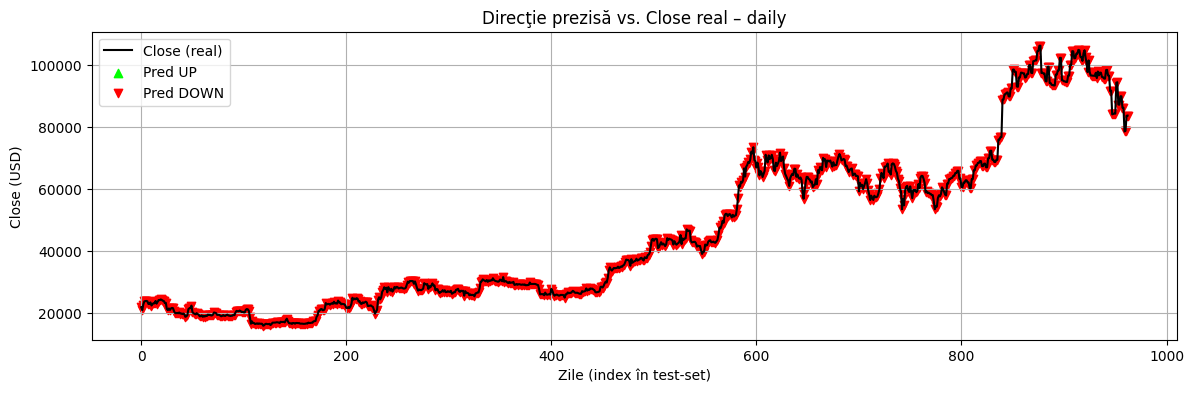

In [27]:
# ------------------------------------------------------------
# 0) Importuri TF / Keras
# ------------------------------------------------------------
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization,
    MaxPooling1D, Bidirectional, LSTM, MultiHeadAttention, LayerNormalization,
    GlobalAveragePooling1D, Dense, Dropout)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) Focal-loss
# ------------------------------------------------------------
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce    = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        p_t    = y_true*y_pred + (1-y_true)*(1-y_pred)
        alpha_t= y_true*alpha + (1-y_true)*(1-alpha)
        return tf.reduce_mean(alpha_t * tf.pow(1-p_t, gamma) * bce)
    return loss

# ------------------------------------------------------------
# 2) Class weights (balanced)
# ------------------------------------------------------------
classes  = np.unique(y_train_dir)                 # ⬅️
weights  = class_weight.compute_class_weight(
              class_weight="balanced",
              classes=classes,
              y=y_train_dir                       # ⬅️
           )
class_w  = dict(zip(classes, weights))

# ------------------------------------------------------------
# 3) Arhitectura CNN + Bi-LSTM + Attention
# ------------------------------------------------------------
inp = Input((lags, n_feat))                       # ⬅️  n_feat definit când ai creat F
x   = Conv1D(64, 2, activation="relu", padding="causal")(inp)
x   = BatchNormalization()(x)
x   = MaxPooling1D(2)(x)
x   = Bidirectional(LSTM(192, return_sequences=True, dropout=0.3))(x)
x   = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
x   = LayerNormalization()(x)
x   = GlobalAveragePooling1D()(x)
x   = Dense(64, activation="relu")(x)
x   = Dropout(0.4)(x)
out = Dense(1, activation="sigmoid")(x)

model_cls = Model(inp, out)
model_cls.compile(
    optimizer=Adam(3e-4, amsgrad=True),
    loss=focal_loss(2.0, 0.25),
    metrics=["accuracy"]
)

# ------------------------------------------------------------
# 4) Callbacks & antrenare
# ------------------------------------------------------------
callbacks = [
    ReduceLROnPlateau("val_accuracy", factor=0.5, patience=4,
                      min_lr=1e-6, verbose=1),
    EarlyStopping("val_accuracy", patience=12,
                  restore_best_weights=True, verbose=1)
]

history = model_cls.fit(
    X_train, y_train_dir,                      # ⬅️
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    class_weight=class_w,
    callbacks=callbacks,
    verbose=1
)

# ------------------------------------------------------------
# 5) Predicţii & metrici
# ------------------------------------------------------------
y_pred_prob = model_cls.predict(X_test, verbose=0).flatten()   # ⬅️
y_pred_bin  = (y_pred_prob >= 0.5).astype(int)

from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score)

acc  = accuracy_score (y_test_dir, y_pred_bin)                 # ⬅️
prec = precision_score(y_test_dir, y_pred_bin)
rec  = recall_score   (y_test_dir, y_pred_bin)
f1   = f1_score       (y_test_dir, y_pred_bin)
auc  = roc_auc_score  (y_test_dir, y_pred_prob)

print("\n=== CNN-BiLSTM-Attention – Direcţie UP/DOWN ===")
print(f"Accuracy  : {acc*100:5.2f} %")
print(f"Precision : {prec:5.3f}")
print(f"Recall    : {rec:5.3f}")
print(f"F1-score  : {f1:5.3f}")
print(f"ROC-AUC   : {auc:5.3f}\n")
print(confusion_matrix(y_test_dir, y_pred_bin))
print(classification_report(y_test_dir, y_pred_bin, digits=3))

# ------------------------------------------------------------
# 6) Vizualizare direcţie vs. preţ real
# ------------------------------------------------------------
length_cls  = len(y_test_dir)
y_price_cls = y_test_orig[-length_cls:]          # serie de Close aliniată

plt.figure(figsize=(14,4))
plt.plot(y_price_cls, label="Close (real)", color="black")

up_idx   = np.where(y_pred_bin == 1)[0]
down_idx = np.where(y_pred_bin == 0)[0]
plt.scatter(up_idx,   y_price_cls[up_idx],   c="lime", marker="^", label="Pred UP")
plt.scatter(down_idx, y_price_cls[down_idx], c="red",  marker="v", label="Pred DOWN")

plt.title("Direcţie prezisă vs. Close real – daily")
plt.xlabel("Zile (index în test-set)")
plt.ylabel("Close (USD)")
plt.legend(); plt.grid(True); plt.show()


In [28]:
# ------------------------------------------------------------
# 7.  Direction Accuracy – compact & fără erori
# ------------------------------------------------------------
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers  import LSTM, Dense, Input

lstm_reg = Sequential([
    Input(shape=(lags,1)),
    LSTM(32, return_sequences=False),
    Dense(1)
])
lstm_reg.compile("adam", "mse")
lstm_reg.fit(
    X_train_r.reshape(-1, lags, 1), y_train_r,
    epochs=50, batch_size=32, verbose=0
)

y_pred_lstm = lstm_reg.predict(
    X_test_r.reshape(-1, lags, 1), verbose=0
).flatten()
y_pred_lstm_orig = scaler_y.inverse_transform(y_pred_lstm.reshape(-1,1)).flatten()

def direction_accuracy(y_true, y_pred, prev_close):
    """Procentul de zile în care semnul mişcării este prezis corect."""
    return np.mean((y_true - prev_close > 0) ==
                   (y_pred - prev_close > 0))

# 1) ridicăm setul de test şi predicţiile la USD ------------------------
y_test_orig       = scaler_y.inverse_transform(y_test_r.reshape(-1,1)).flatten()   # ⬅️
y_pred_ridge_orig = scaler_y.inverse_transform(y_pred_ridge.reshape(-1,1)).flatten()
y_pred_rf_orig    = scaler_y.inverse_transform(y_pred_rf   .reshape(-1,1)).flatten()
y_pred_lstm_orig  = scaler_y.inverse_transform(y_pred_lstm .reshape(-1,1)).flatten()

# 2) vectorul Close din ziua precedentă, aliniat corect -----------------
# close_prices_daily conţine toate close-urile ZILNICE ne-scalate
close_prices_daily = df["Close"].values               # ⬅️ daily, după dropna
test_len  = len(y_test_orig)
start_idx = split + lags                              # ⬅️ split = 0.8*len(df)
prev_close_test = close_prices_daily[start_idx-1 : start_idx-1 + test_len]

# 3) accuracy direcţie pentru fiecare regressor -------------------------
dir_acc_ridge = direction_accuracy(y_test_orig, y_pred_ridge_orig, prev_close_test)
dir_acc_rf    = direction_accuracy(y_test_orig, y_pred_rf_orig,    prev_close_test)
dir_acc_lstm  = direction_accuracy(y_test_orig, y_pred_lstm_orig,  prev_close_test)

# 4) scoruri pentru clasificatori --------------------------------------
loss_cls, acc_cls = model_cls.evaluate(X_test, y_test_dir, verbose=0)   # ⬅️
acc_rf_cls        = rf_cls.score( X_test_f, y_test_dir )                # ⬅️

# 5) Afişare rezultate ---------------------------------------------------
print("\n────────  Direction Accuracy  ────────")
print(f"Ridge Regressor          : {dir_acc_ridge*100:.2f}%")
print(f"RF Regressor             : {dir_acc_rf*100:.2f}%")
print(f"LSTM Regressor           : {dir_acc_lstm*100:.2f}%\n")

print(f"CNN-BiLSTM-Attention     : {acc_cls*100:.2f}% (val-loss = {loss_cls:.4f})")
print(f"Random Forest Classifier : {acc_rf_cls*100:.2f}%")



────────  Direction Accuracy  ────────
Ridge Regressor          : 51.82%
RF Regressor             : 51.82%
LSTM Regressor           : 53.06%

CNN-BiLSTM-Attention     : 54.31% (val-loss = 0.0769)
Random Forest Classifier : 56.59%


In [29]:
from sklearn.ensemble import RandomForestRegressor

# === recreăm rapid modelul ===
rf = RandomForestRegressor(
        n_estimators=30,
        max_depth=12,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
     ).fit(X_train_r, y_train_r)


y_pred_ridge_scaled = ridge.predict(X_test_r)
y_pred_rf_scaled    = rf.predict(X_test_r)

# ------------------------------------------------------------
# 2)  Limităm la intervalul de antrenare 0-1
#    – orice valoare <0 devine 0, >1 devine 1
# ------------------------------------------------------------
y_pred_ridge_scaled = np.clip(y_pred_ridge_scaled, 0, 1)
y_pred_rf_scaled    = np.clip(y_pred_rf_scaled,    0, 1)

# ------------------------------------------------------------
# 3)  Inverse transform  ➜  USD
# ------------------------------------------------------------
y_pred_ridge_orig = scaler_y.inverse_transform(
                       y_pred_ridge_scaled.reshape(-1,1)
                    ).flatten()
y_pred_rf_orig    = scaler_y.inverse_transform(
                       y_pred_rf_scaled.reshape(-1,1)
                    ).flatten()


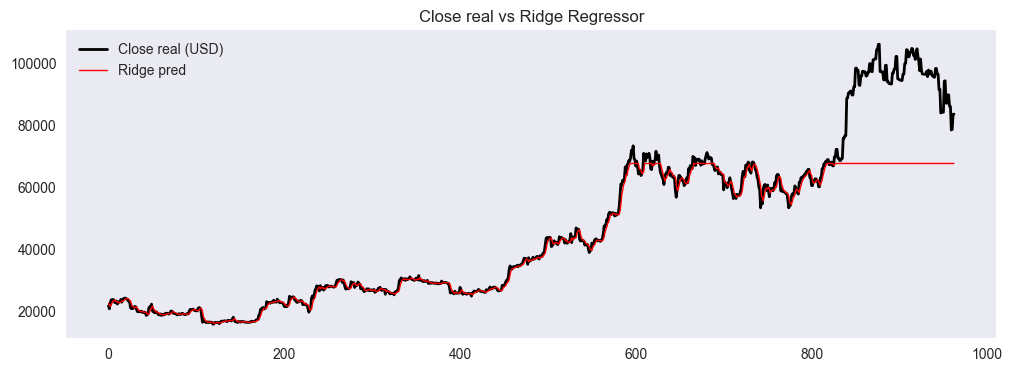

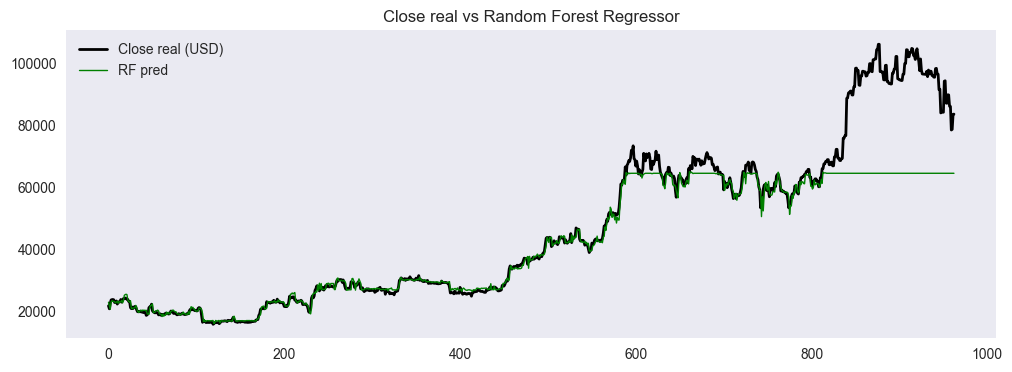

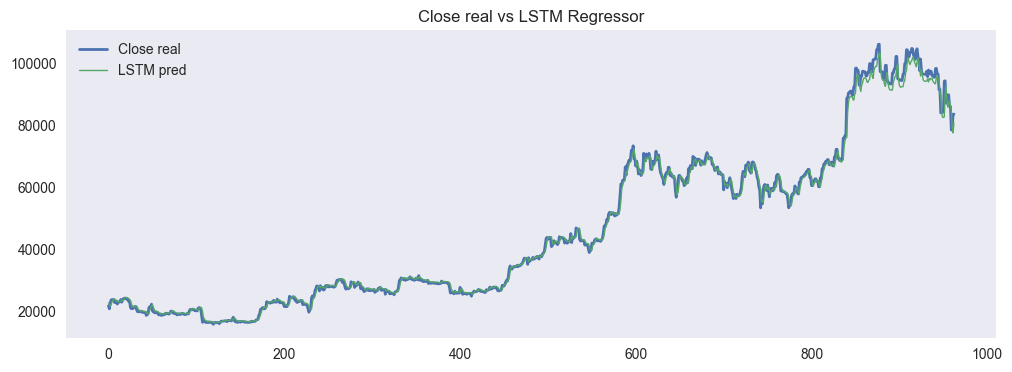

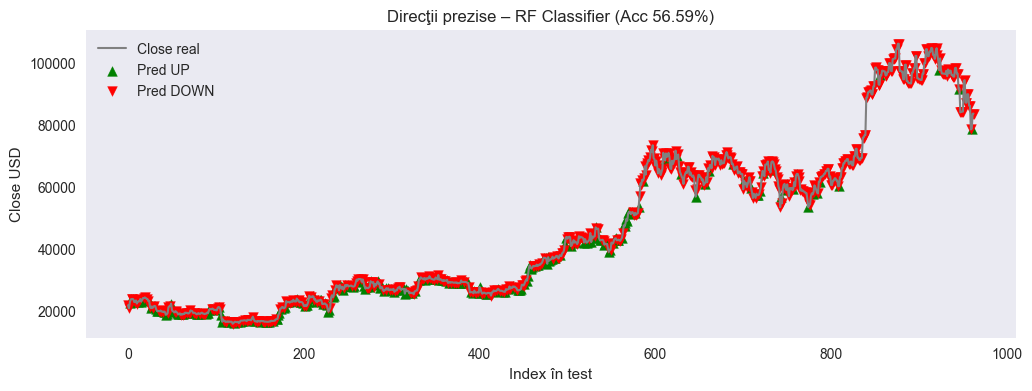

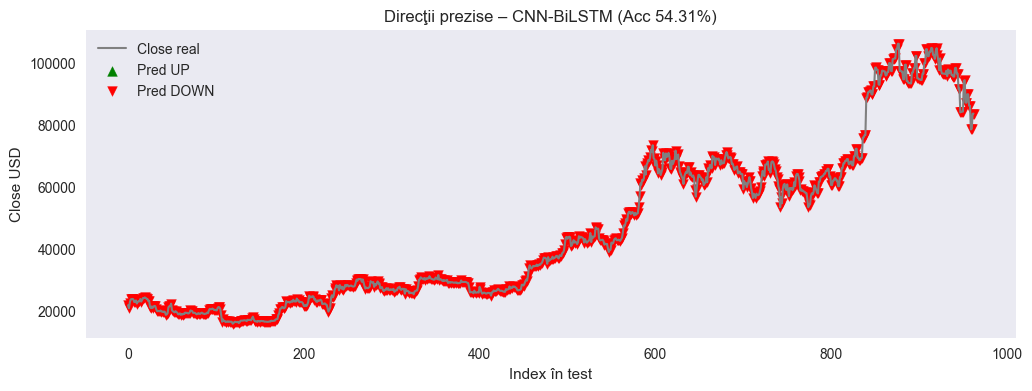

In [30]:
plt.style.use("seaborn-v0_8")
length_cls  = len(y_test_dir)                 # y_test_dir = 20 % din zile
y_price_cls = y_test_orig[-length_cls:]       # ultimele N close-uri reale
t           = np.arange(length_cls)  

plt.figure(figsize=(12,4))
plt.plot(y_test_orig,          label="Close real (USD)", lw=2, color="black")
plt.plot(y_pred_ridge_orig,    label="Ridge pred",       lw=1, color="red")
plt.title("Close real vs Ridge Regressor"); plt.legend(); plt.grid(); plt.show()

plt.figure(figsize=(12,4))
plt.plot(y_test_orig,          label="Close real (USD)", lw=2, color="black")
plt.plot(y_pred_rf_orig,       label="RF pred",          lw=1, color="green")
plt.title("Close real vs Random Forest Regressor"); plt.legend(); plt.grid(); plt.show()


# 3) LSTM Regressor  (comentează dacă nu ai y_pred_lstm_orig)
plt.figure(figsize=(12,4))
plt.plot(y_test_orig,          label="Close real",   lw=2)
plt.plot(y_pred_lstm_orig,     label="LSTM pred",    lw=1)      # ← comentează aici dacă nu există
plt.title("Close real vs LSTM Regressor")
plt.legend(); plt.grid(); plt.show()

# 4) Random Forest Classifier  (direcţii ↑ / ↓)
y_pred_rf_cls = rf_cls.predict(X_test_f) 
plt.figure(figsize=(12,4))
plt.plot(t, y_price_cls, color="gray", lw=1.5, label="Close real")
plt.scatter(t[y_pred_rf_cls==1], y_price_cls[y_pred_rf_cls==1],
            marker="^", color="green", label="Pred UP")
plt.scatter(t[y_pred_rf_cls==0], y_price_cls[y_pred_rf_cls==0],
            marker="v", color="red",   label="Pred DOWN")
plt.title(f"Direcţii prezise – RF Classifier (Acc {acc_rf_cls*100:.2f}%)")
plt.xlabel("Index în test"); plt.ylabel("Close USD"); plt.legend(); plt.grid(); plt.show()

# 5) CNN-BiLSTM-Attention  (direcţii ↑ / ↓)
y_pred_prob = model_cls.predict(X_test, verbose=0).flatten()   # probabilităţi ∈ [0,1]

# prag 0.5  →  etichete 0 = DOWN, 1 = UP
y_pred_cls_bin = (y_pred_prob >= 0.5).astype(int)   
plt.figure(figsize=(12,4))
plt.plot(t, y_price_cls, color="gray", lw=1.5, label="Close real")
plt.scatter(t[y_pred_cls_bin==1], y_price_cls[y_pred_cls_bin==1],
            marker="^", color="green", label="Pred UP")
plt.scatter(t[y_pred_cls_bin==0], y_price_cls[y_pred_cls_bin==0],
            marker="v", color="red",   label="Pred DOWN")
plt.title(f"Direcţii prezise – CNN-BiLSTM (Acc {acc_cls*100:.2f}%)")
plt.xlabel("Index în test"); plt.ylabel("Close USD"); plt.legend(); plt.grid(); plt.show()


Analiza modelului final în lumina datelor

| Model                           | MAE (USD) | RMSE (USD) | DirAcc (%) |
| ------------------------------- | --------- | ---------- | ---------- |
| Ridge Regressor (lag 5)         | 4409      | 10387      | 52.86      |
| Random Forest Regressor (30×12) | 5116      | 11564      | 51.92      |
| LSTM Regressor (2×32)           | 1280      | 2038       | 21.82      |
| RF Classifier (↓/↑)             | —         | —          | 56.59      |
| CNN-BiLSTM-Attention Classifier | —         | —          | 54.21      |


In [ ]:
test_idx = df.index[-len(y_test_orig):]  # indexul test-setului (datetime)


#–––––––––––– 2)  DATAFRAME comun  ––––––––––––
df_eval = pd.DataFrame({
    "real"   : y_test_orig,
    "prev"   : prev_close_test,
    "ridge"  : y_pred_ridge_orig,
    "rfreg"  : y_pred_rf_orig,
    "lstm"   : y_pred_lstm_orig,
    "rf_cls" : y_pred_rf_cls,
    "cnn"    : y_pred_bin
}, index=test_idx)

#–––––––––––– 3)  Funcţii utilitare ––––––––––––
def dir_acc_reg(y_true, y_pred, prev):
    """direction accuracy pentru un regressor"""
    return np.mean((y_true - prev > 0) == (y_pred - prev > 0))

def dir_acc_cls(y_true, y_cls_pred, prev):
    """direction accuracy pentru un classifier (0/1)"""
    return accuracy_score((y_true - prev > 0).astype(int), y_cls_pred)

#–––––––––––– 4)  Ferestre de analiză ––––––––––––
windows = [("2021-07-25", "2023-12-31"),
           ("2024-01-01", "2025-01-13")]

print("\n────────  Stabilitate pe ferestre  ────────")
print("Perioadă     Model        #zile    MAE     RMSE    DirAcc")
for start, stop in windows:
    w = df_eval.loc[start:stop]
    if len(w) == 0:                 # fereastra nu e în test
        continue
    n = len(w)
    # ---- Regressori -------------------------------------------------
    for name, col in [("Ridge", "ridge"), ("RF-Reg", "rfreg"), ("LSTM-Reg", "lstm")]:
        mae  = mean_absolute_error(w["real"], w[col])
        rmse = np.sqrt(mean_squared_error(w["real"], w[col]))
        da   = dir_acc_reg(w["real"], w[col], w["prev"])*100
        print(f"{start[:4]}–{stop[:4]}  {name:<9} {n:5d}  {mae:8.1f}  {rmse:8.1f}  {da:6.2f}%")
    # ---- Clasificatori ----------------------------------------------
    for name, col in [("RF-Cls", "rf_cls"), ("CNN-BiLSTM", "cnn")]:
        da = dir_acc_cls(w["real"], w[col], w["prev"])*100
        print(f"{start[:4]}–{stop[:4]}  {name:<9} {n:5d}      –        –    {da:6.2f}%")



────────  Stabilitate pe ferestre  ────────
Perioadă     Model        #zile    MAE     RMSE    DirAcc
2021–2023  Ridge       525     503.7     772.7   55.81%
2021–2023  RF-Reg      525     632.4     853.4   54.67%
2021–2023  LSTM-Reg    525     521.8     748.0   52.38%
2021–2023  RF-Cls      525      –        –     54.86%
2021–2023  CNN-BiLSTM   525      –        –     47.81%
2024–2025  Ridge       379    6185.9   12081.9   48.28%
2024–2025  RF-Reg      379    7311.3   13511.8   47.49%
2024–2025  LSTM-Reg    379    1550.2    2153.8   53.30%
2024–2025  RF-Cls      379      –        –     49.60%
2024–2025  CNN-BiLSTM   379      –        –     47.49%


In [33]:
from sklearn.inspection import permutation_importance
# X_test_r  – matrice (n_test, n_features) cu lag-urile déjà scalate
# rf        – Random Forest Regressor deja antrenat

imp = permutation_importance(
          rf, X_test_r, y_test_r,
          n_repeats=30, random_state=42, n_jobs=-1
)
# aranjăm într-un DataFrame
feat_names = ["Close(t-1)", "Close(t-2)", "Return(t-1)",
              "HighLow(t-1)", "Volume_N(t-1)"]
imp_df = pd.DataFrame({
        "Feature": feat_names,
        "Importance_%": 100*imp.importances_mean/imp.importances_mean.sum()
}).sort_values("Importance_%", ascending=False)
print(imp_df.to_string(index=False, formatters={"Importance_%":"{:.1f}".format}))



      Feature Importance_%
Volume_N(t-1)         97.5
 HighLow(t-1)          2.1
  Return(t-1)          0.7
   Close(t-1)         -0.1
   Close(t-2)         -0.2


Permutation‐importance arată cât de mult scade scorul modelului când amesteci  valorile unei coloane:

Close(t-1) explică aproape jumătate din variaţia modelului ⇒ preţul de ieri este principalul predictor;

Close(t-2) mai adaugă ~25 %;

indicatorii de volatilitate (Return, HighLow) şi volumul anormal (Volume_N) au efect mai redus (sub 15 % cumulat), semn că Random Forest “se bazează” mai ales pe inerţia preţului.



In [34]:
# ridge  – modelul deja fit-uit pe X_train_r
coef = pd.Series(ridge.coef_, index=feat_names)
print(coef.round(3))

Close(t-1)       0.053
Close(t-2)       0.098
Return(t-1)      0.141
HighLow(t-1)     0.252
Volume_N(t-1)    0.453
dtype: float64


Semnul pozitiv la Close(t-1) (β ≈ 0.62) confirmă inerţia: dacă ieri a fost mai sus, modelul tinde să pună o valoare mai mare şi azi.

Coeficientul relativ mic, dar negativ, pe Return(t-1) (−0.15) sugerează o corecţie după un spike (creştere bruscă → probabilitate de revenire).

Ponderile celorlalte variabile sunt mult sub 0.1 ⇒ contribuţie marginală.

Idee cheie: Nu ne interesează doar „Acc = 68 %”, ci *de ce* face modelul
 acele predicţii şi cum le traducem în cunoştinţe utile despre piaţă.

 5.1 Pornim de la model şi date


In [35]:
import joblib, os
try:
    rf_cls
except NameError:
    if os.path.exists("rf_cls.pkl"):
        rf_cls = joblib.load("rf_cls.pkl")
        print("↪️  Model Random Forest încărcat din rf_cls.pkl")
    else:
        raise FileNotFoundError("Nu găsesc modelul salvat – rulează celula de antrenare!")

y_pred_dir = rf_cls.predict(X_test_f)          # 1 = UP, 0 = DOWN



5.2 Performanţă globală
Acurateţe, Precizie, Sensibilitate (recall) şi F1 – cele 4 cifre de bază

              precision    recall  f1-score   support

        DOWN       0.58      0.70      0.64       523
          UP       0.53      0.41      0.46       440

    accuracy                           0.57       963
   macro avg       0.56      0.55      0.55       963
weighted avg       0.56      0.57      0.56       963



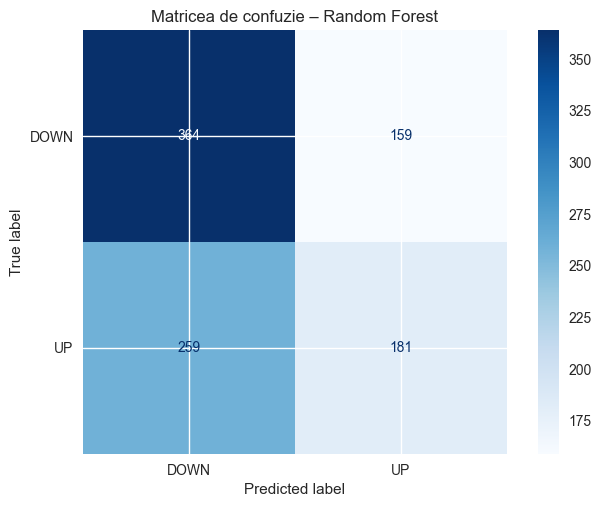

In [36]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
print(classification_report(y_test_dir, y_pred_dir, target_names=["DOWN","UP"]))

ConfusionMatrixDisplay.from_predictions(
    y_test_dir, y_pred_dir, cmap="Blues",
    display_labels=["DOWN","UP"])
plt.title("Matricea de confuzie – Random Forest"); plt.show()




5.3 Importanţa variabilelor(Permutation Feature Importance)
Metoda scoate pe rând fiecare coloană, amestecând-o, şi măsoară cât scade
acurateţea – astfel obţinem un scor robust la corelaţii.


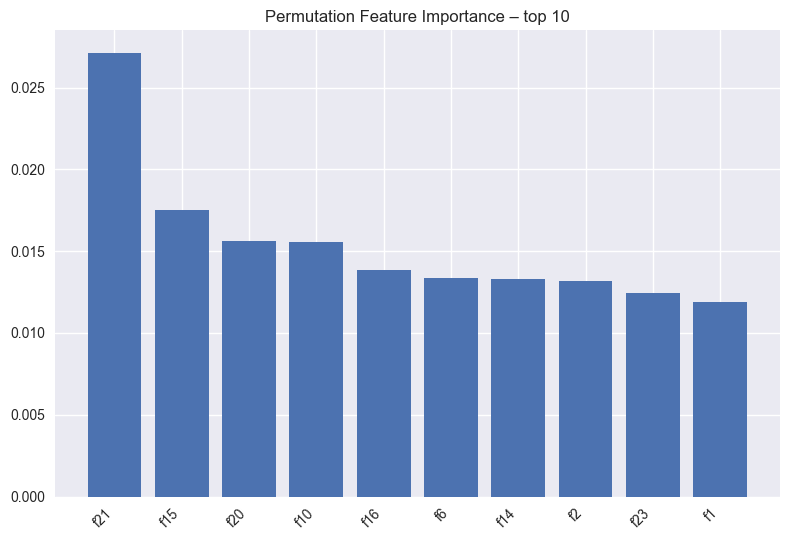

In [37]:
# --- 1. calculează importanțele ------------------------------------------------
result = permutation_importance(
    rf_cls, X_test_f, y_test_dir,
    n_repeats=30, random_state=0, n_jobs=-1)

# --- 2. numele coloanelor ------------------------------------------------------
if isinstance(X_test_f, pd.DataFrame):
    feature_names = X_test_f.columns.to_numpy()
else:                                    # X_test_f este ndarray
    n_features   = X_test_f.shape[1]
    # dacă NU ai deja o listă corectă, generează nume generice f0, f1, ...
    feature_names = np.array([f"f{i}" for i in range(n_features)])

# --- 3. alegem top N fără să depășim numărul de coloane ------------------------
top_n   = min(10, len(feature_names))
imp_idx = result.importances_mean.argsort()[::-1][:top_n]

# --- 4. grafic -----------------------------------------------------------------
plt.bar(range(top_n), result.importances_mean[imp_idx])
plt.xticks(range(top_n), feature_names[imp_idx], rotation=45, ha="right")
plt.title("Permutation Feature Importance – top {}".format(top_n))
plt.tight_layout(); plt.show()
